# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png'>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Package imports.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import json
from time import time
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from workspace_utils import active_session

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Directories.

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Data augmentation and Normalization.

# Defining transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                           transforms.RandomResizedCrop(244),
                                                           transforms.RandomHorizontalFlip(),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])
                                                          ]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                                           transforms.RandomResizedCrop(244),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])
                                                          ])}

# Loading the datasets with ImageFolder.
image_datasets = {'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                  'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
                  'test': datasets.ImageFolder(test_dir, transform=data_transforms['valid'])
                 }

# Using the image datasets and the transforms to define the dataloaders.
dataloaders = {'trainloader': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
               'validloader': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32),
               'testloader': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32)
              }

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# TODO: Build and train your network

In [7]:
# Defining a class for the feedforward network.

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer.
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers.
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output log softmax.
            Arguments
            ---------
            self: all layers
            x: tensor vector
        '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout.        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [8]:
# Definig a function for the validation pass.

def validation(model, validloader, criterion, device):
    ''' Builds a feedforward network with arbitrary hidden layers, 
        returns the validation loss and  validation accuracy.
        
        Arguments
        ---------
        model: the pre-trained model.
        validloader: generator, the validation dataset.
        criterion: loss function.
        device: the used device for the training [GPU or CPU].
    '''
    # Initiate the validation accuracy & validation loss with 0.
    valid_accuracy = 0
    valid_loss = 0
    # Move model to the device
    model.to(device)
    
    # Looping through the data batches.
    for inputs, labels in validloader:
        # Move input and label tensors to the device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass through the network.
        output = model.forward(inputs)
        # Increase the validation loss by the loss of the predicted output with the labels.
        valid_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, so take exponential to get the probabilities.
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label.
        equality = (labels.data == ps.max(dim=1)[1])
        # Accuracy is number of correct predictions divided by all predictions, so we just take the mean.
        valid_accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, valid_accuracy

In [9]:
# Definig a function for the training process

def training(model, criterion, optimizer, device, trainloader, validloader, epochs=5, print_every=40):
    ''' Builds a feedforward network with arbitrary hidden layers.
        
        Arguments
        ---------
        model: the pre-trained model.
        optimizer: which we will take a step with it to update the weights.
        criterion: loss function.
        device: the used device for the training [GPU or CPU].
        trainloader: generator, the training dataset.
        validloader: generator, the validation dataset.
        epochs: integer, number of trainings.
        print_every: integer, printing the updates on loss & accuracy every print_every value.
    '''
    
    steps = 0
    running_loss = 0
    # Move model to the device
    model.to(device)
    
    for e in range(epochs):
        # Model in training mode, dropout is on.
        model.train()
        for inputs, labels in trainloader:
            # Move input and label tensors to the device.
            inputs, labels = inputs.to(device), labels.to(device)
            
            steps += 1
            # zero-ing the accumalated gradients.
            optimizer.zero_grad()
            
            # Forward pass through the network
            output = model.forward(inputs)
            # Calculate the loss
            loss = criterion(output, labels)
            # Backward pass through the network 
            loss.backward()
            # Take a step with the optimizer to update the weights
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation saves memory and computations, so will speed up inference
                with torch.no_grad():
                    valid_loss, valid_accuracy = validation(model, validloader, criterion, device)
                
                # Displaying the validation loss and accuracy during the training. 
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(valid_accuracy/len(validloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are back on for training
                model.train()

In [10]:
# Using a Pretrained Network
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 92733983.58it/s] 


In [11]:
# Setting all hyper parameters in a dictionary to ease the dealing.
hyper_parameters = {'input_size': 25088,
                    'output_size': 102,
                    'hidden_layers': [1024],
                    'drop_p': 0.2,
                    'learn_rate': 0.0001,
                    'epochs': 8,
                    'model': 'vgg19'
                   }

In [12]:
# Freezing the parameters so we don't backprop through them, 
# we will backprop through the classifier parameters only later
for param in model.parameters():
    param.requires_grad = False

# Creating Feedforward Classifier
classifier = Network(input_size = hyper_parameters['input_size'], 
                     output_size = hyper_parameters['output_size'], 
                     hidden_layers = hyper_parameters['hidden_layers'], 
                     drop_p = hyper_parameters['drop_p'])

model.classifier = classifier

In [13]:
# Define the criterion (Loss function). 
criterion = nn.NLLLoss()
# Define the optimizer. Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=hyper_parameters['learn_rate'])

In [14]:
# Checking if the 'GPU' is available to pass it for the device variable, and if it's not, pass the 'CPU'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Train the model with a pre-trained network.

with active_session():
    # do long-running work here
    training(model, criterion, optimizer, device,
             trainloader = dataloaders['trainloader'],
             validloader = dataloaders['validloader'],
             epochs = hyper_parameters['epochs'])

Epoch: 1/8..  Training Loss: 3.794..  Validation Loss: 3.028..  Validation Accuracy: 0.381
Epoch: 1/8..  Training Loss: 2.493..  Validation Loss: 2.129..  Validation Accuracy: 0.564
Epoch: 2/8..  Training Loss: 1.822..  Validation Loss: 1.608..  Validation Accuracy: 0.658
Epoch: 2/8..  Training Loss: 1.467..  Validation Loss: 1.425..  Validation Accuracy: 0.681
Epoch: 2/8..  Training Loss: 1.354..  Validation Loss: 1.278..  Validation Accuracy: 0.701
Epoch: 3/8..  Training Loss: 1.081..  Validation Loss: 1.179..  Validation Accuracy: 0.737
Epoch: 3/8..  Training Loss: 1.058..  Validation Loss: 1.075..  Validation Accuracy: 0.760
Epoch: 4/8..  Training Loss: 0.955..  Validation Loss: 0.993..  Validation Accuracy: 0.771
Epoch: 4/8..  Training Loss: 0.873..  Validation Loss: 0.936..  Validation Accuracy: 0.779
Epoch: 4/8..  Training Loss: 0.811..  Validation Loss: 0.896..  Validation Accuracy: 0.781
Epoch: 5/8..  Training Loss: 0.798..  Validation Loss: 0.885..  Validation Accuracy: 0.787

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set

In [18]:
# Dfefining a function for testing

def testing(model, testloader):
    ''' Builds a function to test the model, returns the testing accuracy.
        
        Arguments
        ---------
        model: the pre-trained model.
        testloader: generator, the testing dataset.
    '''
    
    # Checking if the 'GPU' is available to pass it for the device variable, and if it's not, pass the 'CPU'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Model in inference mode, dropout is off
    model.eval()
    # Move model to the device
    model.to(device)
    accuracy = 0
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Turn off gradients for testing saves memory and computations, so will speed up inference
        with torch.no_grad():
            # Forward pass through the network to get the outputs
            output = model.forward(inputs)
        
        # take exponential to get the probabilities from log softmax output.
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    test_accuracy = accuracy / len(testloader)
    
    return test_accuracy

In [19]:
test_accuracy = testing(model, dataloaders['testloader'])

print("Test Accuracy: {:.3f}".format(test_accuracy))

Test Accuracy: 0.791


In [20]:
# Avergae testing

test_sum = 0
for i in range(5):
    start = time()
    test_accuracy = testing(model, dataloaders['testloader'])
    test_sum += test_accuracy
    print("Test Accuracy{}: {:.3f}".format(i, test_accuracy))
    print("testing vgg19_2.pth time = ", time() - start)
    print()

print("Average Test Accuracy: {:.3f}".format(test_sum/5))

Test Accuracy0: 0.780
testing vgg19_2.pth time =  28.571154594421387

Test Accuracy1: 0.781
testing vgg19_2.pth time =  28.62717056274414

Test Accuracy2: 0.800
testing vgg19_2.pth time =  28.415693521499634

Test Accuracy3: 0.794
testing vgg19_2.pth time =  28.576252937316895

Test Accuracy4: 0.780
testing vgg19_2.pth time =  28.406853914260864

Average Test Accuracy: 0.787


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
# TODO: Save the checkpoint

In [22]:
# Saving the model, weights, biases, mapping of classes to indices, and hyper parameters to rebuild the model.

model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'input_size': hyper_parameters['input_size'],
              'output_size': hyper_parameters['output_size'],
              'hidden_layers': hyper_parameters['hidden_layers'],
              'drop_p': hyper_parameters['drop_p'],
              'model': hyper_parameters['model'],
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict()}

filepath = 'vgg19.pth'

torch.save(checkpoint, filepath)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [23]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

In [24]:
# Defining a function that loads a checkpoint and rebuilds the model.

def load_checkpoint(filepath):
    ''' Builds a function to load the model, returns the model.
        
        Arguments
        ---------
        filepath: string, the path of the model checkpoint.
    '''
    # Loading the checkpoint
    checkpoint = torch.load(filepath)
    # using the pre-trained Network
    if checkpoint['model'] == 'vgg19':
        model = models.vgg19(pretrained=True)
    
    # Freezing the parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
       
    # Creating the Feedforward Classifier
    classifier = Network(input_size = checkpoint['input_size'],
                         output_size = checkpoint['output_size'],
                         hidden_layers = checkpoint['hidden_layers'], 
                         drop_p = checkpoint['drop_p'])
    
    # Replacing pre-trained calssifier by ours.
    model.classifier = classifier
    # Loading the weights and biases.
    model.load_state_dict(checkpoint['state_dict'])
    # Loading the classes to indices of our saved model.
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [25]:
# Loading the model & Calculating the spent time.
start = time()
filepath = 'vgg19.pth'
model = load_checkpoint(filepath)
print("Loading vgg19.pth time = ", time() - start)

Loading vgg19.pth time =  0.8534862995147705


In [26]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [27]:
# Defineing a function to process the input image, so it can be used as input for the model

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image and converts  into an object 
        that can be used as input to a trained model, returns an Numpy array.

        Arguments
        ---------
        image_path: string, path of the image.
    '''
    
    im = Image.open(image_path)
    # Process a PIL image for use in a PyTorch model
    preprocess = transforms.Compose([transforms.Resize(256),
                                     transforms.RandomResizedCrop(244),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
    preprocessed_im = preprocess(im)
    
    return preprocessed_im

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [28]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [29]:
# chech process_image() fun.

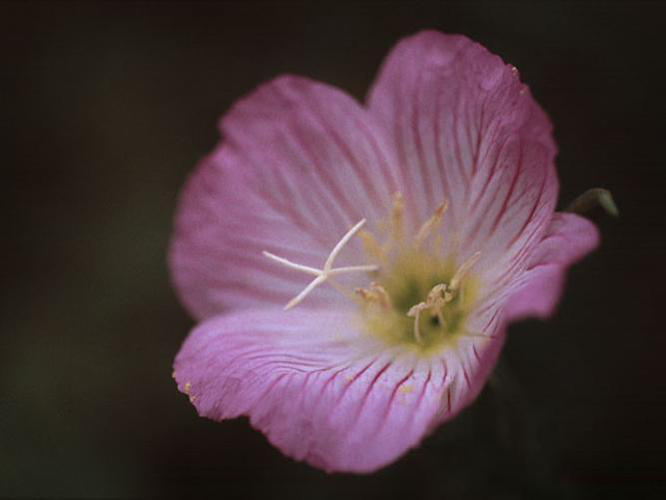

In [30]:
path = './flowers/valid/1/image_06756.jpg'
Image.open(path)

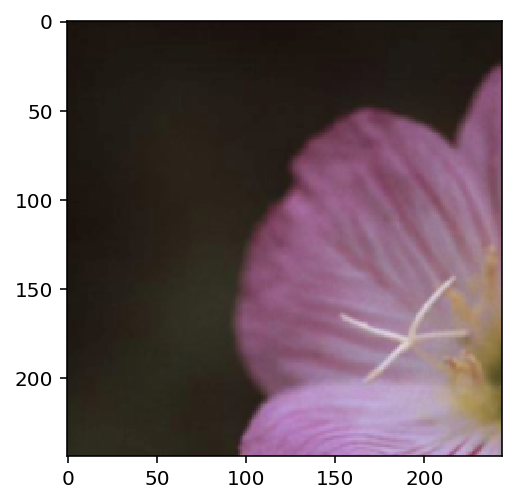

In [31]:
image = process_image(path)
imshow(image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [32]:
# Defining a function to predict the class of the label image.

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model,
        returns the probabilities and classes of most likely (k) prescited classes.
        
        Arguments
        ---------
        image_path: string, path of the image.
        model: the pre-trained model.
        topk: integer, number of most likely (k) classes.
    '''
    
    # Checking if the 'GPU' is available to pass it for the device variable, and if it's not, pass the 'CPU'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Move model to the device
    model.to(device)
    # Model in inference mode, dropout is off
    model.eval()
    
    image = process_image(image_path)
    #print(image.size()) >>> torch.Size([3, 244, 244])
    image.unsqueeze_(0) 
    #print(image.size()) >>> torch.Size([1, 3, 244, 244])
    
    # Move image tensors to the device.
    image = image.to(device)
    
    # Turn off gradients for testing saves memory and computations, so will speed up inference.
    with torch.no_grad():
        # Forward pass through the network to get the outputs.
        prediction = model.forward(image)
    # Take exponential to get the probabilities from log softmax output.
    ps = torch.exp(prediction)
    # The most likely (topk) predicted prbabilities with their indices.
    probs, top_k_indices = ps.topk(topk)
    
    # Extracting the classes from the indices.
    classes = []
    for indice in top_k_indices.cpu()[0]:
        classes.append(list(model.class_to_idx)[indice.numpy()]) # Here we take the class from the index.
    
    return probs.cpu()[0].numpy(), classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [33]:
# TODO: Display an image along with the top 5 classes

In [34]:
# Defining a function to map the category labels to category names

def predict_classes_names(image_path, model, cat_to_name, topk=5):
    ''' Mapping the category labels to category names, returns the category names and the probabilities.
        
        Arguments
        ---------
        image_path: string, path of the image.
        model: the pre-trained model.
        cat_to_name: dict, label mapping from category label to category name. 
        topk: integer, number of most likely (k) classes.
    '''
    
    # Obtaining the predicted probabilities and classes from predict function.
    probs, classes = predict(image_path, model, topk)

    # Opening the json file by using with statemnt to be closed after finishing.
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    
    # Creating the classes_names list from the classes labels.
    classes_names = []
    for i in classes:
        classes_names.append(cat_to_name[str(i)])
    
    return probs, classes_names

In [37]:
def prediction_displaying(image_path, probs, classes_names, cat_to_name):
    ''' Function for displaying the label image and it's most likely predicted class (classes).
    '''
    image = Image.open(image_path)
    
    # Creating axes to subplot
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    # Extracting the the class from the path to map it with category name.
    flower_name = cat_to_name[image_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    tick_names = np.arange(len(probs))
    ax2.barh(tick_names, probs, align='center')
    ax2.set_yticks(tick_names)
    ax2.set_yticklabels(classes_names)
    # inverting the element to be displayed from top to bottom.
    ax2.invert_yaxis()
    ax2.set_title('Class Probability')
    
    # Displaying the probability of each class along with bar.
    for i in range(probs.shape[0]):
        count = probs[i]
        pct_string = '{:0.1f}%'.format(count*100)
        plt.text(x = count, y = i, s = pct_string, va = 'center');

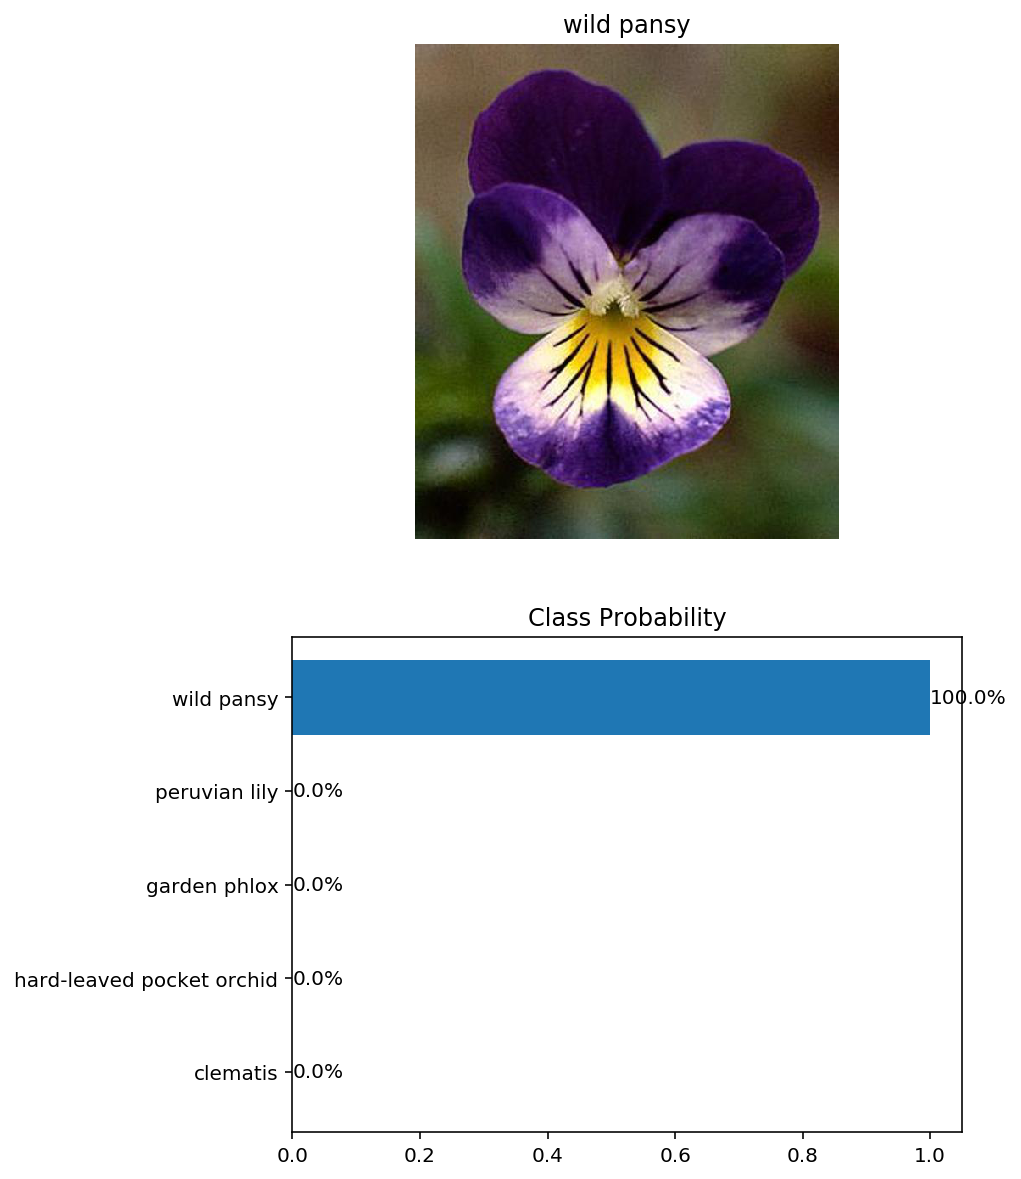

In [38]:
# Testing image.
image_path = './flowers/test/52/image_04221.jpg'

# Calling predict_classes_names to obtain the most likely 5 predicted classes with their prbabilities.
probs, classes_names = predict_classes_names(image_path, model, cat_to_name, topk=5)

# Calling prediction_displaying to display the image with the predicted classes.
prediction_displaying(image_path, probs, classes_names, cat_to_name)